In [265]:
from torch_geometric.data import HeteroData
from torch_geometric.datasets import Entities
from torch_geometric.transforms.random_node_split import RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GraphConv, to_hetero
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import torch
import matplotlib.pyplot as plt
import numpy as np

In [258]:
data = torch.load('data/hetero_data.pt')
data = T.ToUndirected()(data)
data = T.NormalizeFeatures()(data)
split = RandomNodeSplit(num_test=0.33, num_val=0.2)

data = split(data)

In [259]:
data

HeteroData(
  incident={
    x=[141707, 51],
    y=[141707],
    train_mask=[141707],
    val_mask=[141707],
    test_mask=[141707],
  },
  support_org={ x=[141707, 17] },
  customer={ x=[141707, 16] },
  vendor={ x=[141707, 16] },
  (incident, assigned, support_org)={ edge_index=[2, 141707] },
  (incident, assigned, vendor)={ edge_index=[2, 141707] },
  (incident, reported, customer)={ edge_index=[2, 141707] },
  (support_org, rev_assigned, incident)={ edge_index=[2, 141707] },
  (vendor, rev_assigned, incident)={ edge_index=[2, 141707] },
  (customer, rev_reported, incident)={ edge_index=[2, 141707] }
)

In [260]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels, aggr='mean')
        self.conv2 = SAGEConv((-1, -1), out_channels, aggr='mean')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.sigmoid(self.conv2(x, edge_index))

        return x


gcn = GCN(hidden_channels=256, out_channels=2)
gcn = to_hetero(gcn, data.metadata(), aggr='sum')
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001, weight_decay=5e-4)

In [261]:
def train(model, data, optimizer, loss, n_epochs=200):
    train_accs = []
    val_accs = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model(data.x_dict, data.edge_index_dict)
        mask = data['incident'].train_mask
        loss_fn = F.cross_entropy(out['incident'][mask], data['incident'].y[mask].type(torch.LongTensor))
        loss_fn.backward(retain_graph=True)
        optimizer.step()

        val_acc = evaluate(model, data, data['incident'].val_mask, test_flag=False)
        train_acc = (out['incident'][mask].argmax(dim=-1) == data['incident'].y[mask]).sum()/float(mask.sum())
        if epoch % 10 == 0:
            print(f'\tEpoch: {epoch}, train_acc: {train_acc:.5f}, val_acc: {val_acc:.5f}')

        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_accs, val_accs


def evaluate(model, data, mask, test_flag):
    with torch.no_grad():
        model.eval()
        out = model(data.x_dict, data.edge_index_dict)['incident']
        pred = out.argmax(dim=-1)
        correct = (pred[mask] == data['incident'].y[mask]).sum()

        acc_score = correct/float(mask.sum())
        
        if test_flag:
            print(confusion_matrix(pred[mask], data['incident'].y[mask]))

        return acc_score

In [262]:
EPOCHS = 100
train_accuracies, val_accuracies = train_losses, val_losses = train(gcn, data, optimizer, None, EPOCHS)

 10%|████████                                                                         | 10/100 [01:11<10:45,  7.18s/it]

	Epoch: 10, train_acc: 0.51552, val_acc: 0.51858


 20%|████████████████▏                                                                | 20/100 [02:20<09:02,  6.78s/it]

	Epoch: 20, train_acc: 0.52152, val_acc: 0.52098


 30%|████████████████████████▎                                                        | 30/100 [03:29<08:01,  6.88s/it]

	Epoch: 30, train_acc: 0.52637, val_acc: 0.52588


 40%|████████████████████████████████▍                                                | 40/100 [04:45<07:55,  7.92s/it]

	Epoch: 40, train_acc: 0.53577, val_acc: 0.53304


 50%|████████████████████████████████████████▌                                        | 50/100 [05:59<05:53,  7.07s/it]

	Epoch: 50, train_acc: 0.54561, val_acc: 0.54321


 60%|████████████████████████████████████████████████▌                                | 60/100 [07:15<05:05,  7.63s/it]

	Epoch: 60, train_acc: 0.55197, val_acc: 0.54663


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [08:31<03:43,  7.44s/it]

	Epoch: 70, train_acc: 0.55044, val_acc: 0.54352


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [09:40<02:16,  6.82s/it]

	Epoch: 80, train_acc: 0.54855, val_acc: 0.54292


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [10:52<01:11,  7.11s/it]

	Epoch: 90, train_acc: 0.54796, val_acc: 0.54190


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:05<00:00,  7.26s/it]

	Epoch: 100, train_acc: 0.54801, val_acc: 0.54282


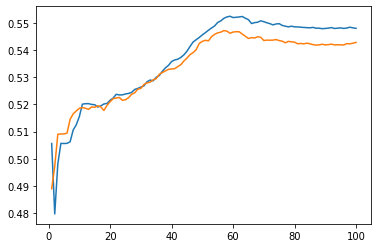

In [263]:
plt.plot(np.arange(1, EPOCHS+1), train_accuracies)
plt.plot(np.arange(1, EPOCHS+1), val_accuracies)

In [266]:
acc_score = evaluate(gcn, data, data['incident'].test_mask, test_flag=True)
acc_score

[[10309  8375]
 [12724 15355]]


tensor(0.5488)